<a href="https://colab.research.google.com/github/UtG1209/Supply-Chain-Optimization/blob/main/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle

In [ ]:
# Import training and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [ ]:
dates = train['date']
sales = train['sales']

In [ ]:
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.isocalendar().week

    # Additionnal Data Features
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))

    # Drop date
    df.drop('date', axis=1, inplace=True)

    return df

In [ ]:
# Dates Features for Train, Test
train, test = date_features(train), date_features(test)

In [ ]:
# Daily Average, Monthly Average for train
train['daily_avg']  = train.groupby(['item','store','dayofweek'])['sales'].transform('mean')
train['monthly_avg'] = train.groupby(['item','store','month'])['sales'].transform('mean')
train = train.dropna()

# Average sales for Day_of_week = d per Item,Store
daymonth_avg = train.groupby(['item','store','dayofweek'])['sales'].mean().reset_index()
# Average sales for Month = m per Item,Store
monthly_avg = train.groupby(['item','store','month'])['sales'].mean().reset_index()

In [ ]:
# Merge Test with Daily Avg, Monthly Avg
def merge(df1, df2, col,col_name):

    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col,left_index=False, right_index=False, sort=True,copy=True, indicator=False)

    df1 = df1.rename(columns={'sales':col_name})
    return df1

# Add Daily_avg and Monthly_avg features to test
test = merge(test, daymonth_avg,['item','store','dayofweek'],'daily_avg')
test = merge(test, monthly_avg,['item','store','month'],'monthly_avg')

In [ ]:
# Sales Rolling mean sequence per item
rolling_10 = train.groupby(['item'])['sales'].rolling(10).mean().reset_index().drop('level_1', axis=1)
train['rolling_mean'] = rolling_10['sales']
train = train.dropna()
a = train['rolling_mean']
a.isna().sum()


0

In [ ]:
# 90 last days of training rolling mean sequence added to test data
rolling_last90 = train.groupby(['item','store'])['rolling_mean'].tail(90).copy()
test['rolling_mean'] = rolling_last90.reset_index().drop('index', axis=1)
a = test['rolling_mean']
a.isna().sum()

0

In [ ]:
# Shifting rolling mean 3 months
train['rolling_mean'] = train.groupby(['item'])['rolling_mean'].shift(90) # Create a feature with rolling mean of day - 90
train.head()
train = train.dropna()
a = train['rolling_mean']
a.isna().sum()

0

In [ ]:
train.head()

,store,item,sales,year,month,day,dayofyear,dayofweek,weekofyear,day^year,daily_avg,monthly_avg,rolling_mean
99,1,1,19,2013,4,10,100,2,15,19.881394,18.793103,20.786667,11.3
100,1,1,16,2013,4,11,101,3,15,19.909116,19.452107,20.786667,10.9
101,1,1,18,2013,4,12,102,4,15,19.936510,21.015326,20.786667,10.5
102,1,1,17,2013,4,13,103,5,15,19.963583,22.973180,20.786667,10.1
103,1,1,26,2013,4,14,104,6,15,19.990341,23.796935,20.786667,10.0


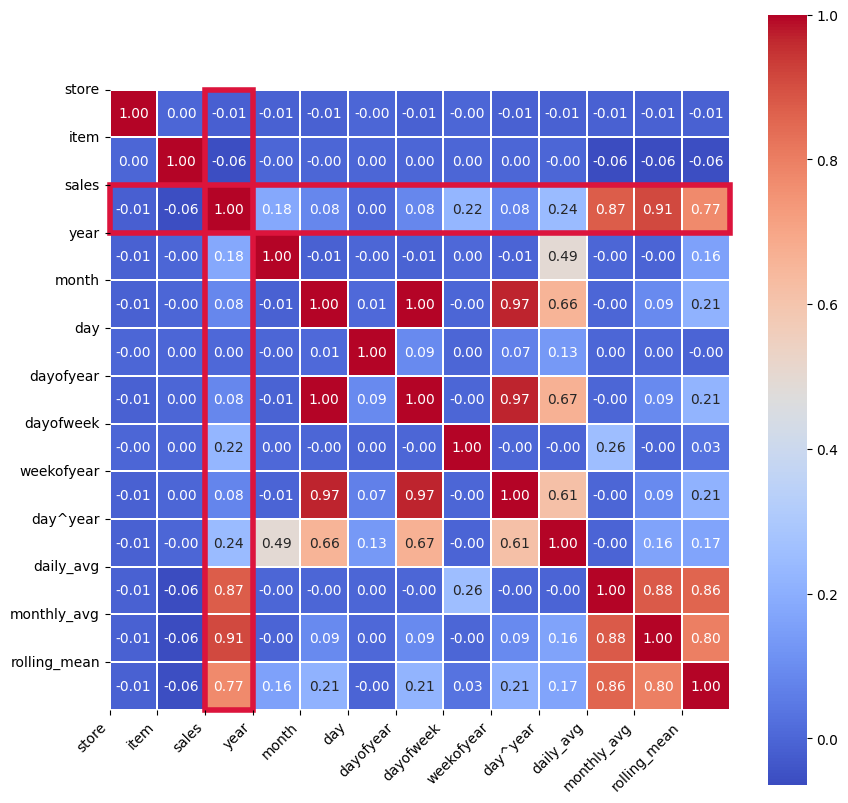

In [ ]:
# Calculate the correlation matrix excluding non-numeric columns
matrix = train.select_dtypes(include=[np.number]).corr()

#extracting variable names
variables = []
for i in matrix.columns:
  variables.append(i)
N = len(variables)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(matrix, cmap='coolwarm', annot=True, linewidths=.2,xticklabels=variables, yticklabels=variables,fmt='.2f')

wanted_label = 'sales'
wanted_index = variables.index(wanted_label)
x, y, w, h = 0, wanted_index, N, 1
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='crimson', lw=4, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h


# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)
ax.set_aspect("equal")
# Display the plot
plt.show()

In [ ]:
# removing low co relation columns
for df in [train, test]:
  df.drop(['dayofyear', 'weekofyear', 'daily_avg', 'day', 'month', 'item', 'store',], axis=1, inplace=True)

In [ ]:
train.std()

sales           28.815751
year             1.410113
dayofweek        1.999312
day^year         4.424183
monthly_avg     26.255270
rolling_mean    26.957906
dtype: float64

In [ ]:
train.mean()

sales             52.362955
year            2015.011453
dayofweek          3.001762
day^year          23.569737
monthly_avg       52.327734
rolling_mean      52.208570
dtype: float64

In [ ]:
test.mean()

id              22499.500000
year             2018.000000
dayofweek           2.966667
day^year           22.245786
monthly_avg        40.781417
rolling_mean       55.315978
dtype: float64

In [ ]:
test.std()

id              12990.525394
year                0.000000
dayofweek           1.985805
day^year            5.787581
monthly_avg        19.559419
rolling_mean       26.739010
dtype: float64

In [ ]:
X_train = train.drop('sales', axis=1).dropna()
y_train = train['sales']
# Test Data
test.sort_values(by=['id'], inplace=True)
X_test = test.drop('id', axis=1)

In [ ]:
X_train.head()

,year,dayofweek,day^year,monthly_avg,rolling_mean
99,2013,2,19.881394,20.786667,11.3
100,2013,3,19.909116,20.786667,10.9
101,2013,4,19.936510,20.786667,10.5
102,2013,5,19.963583,20.786667,10.1
103,2013,6,19.990341,20.786667,10.0


In [ ]:
X_test.head()

,year,dayofweek,day^year,monthly_avg,rolling_mean
0,2018,0,-6.597233,13.709677,21.5
5,2018,1,1.692861,13.709677,20.4
10,2018,2,5.879417,13.709677,18.8
15,2018,3,8.565930,13.709677,19.8
19,2018,4,10.497565,13.709677,23.4


In [ ]:
# prompt: train a model using for the train dataset to predict sales
df_train = train.copy()

X_train , X_test ,y_train, y_test = train_test_split(df_train.drop('sales',axis=1),df_train.pop('sales'), random_state=123, test_size=0.2)

# XGB Model
matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_test = xgb.DMatrix(X_test, label = y_test)

# Run XGB
params = {'objective': 'reg:linear', 'eval_metric': 'mae', 'eta': 0.3, 'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8}

model = xgb.train(params, dtrain=matrix_train, num_boost_round=500, early_stopping_rounds=100, evals=[(matrix_test, 'test')])
# Convert X_test to DMatrix before prediction
test_matrix = xgb.DMatrix(X_test)  # Create DMatrix for X_test
y_pred = model.predict(test_matrix)  # Use DMatrix for prediction

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared:", r2_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:28:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	test-mae:16.82748
[1]	test-mae:12.55321
[2]	test-mae:9.73911
[3]	test-mae:7.98771
[4]	test-mae:6.93883
[5]	test-mae:6.33987
[6]	test-mae:6.00356
[7]	test-mae:5.82338
[8]	test-mae:5.72500
[9]	test-mae:5.67166
[10]	test-mae:5.64207
[11]	test-mae:5.62630
[12]	test-mae:5.61667
[13]	test-mae:5.61120
[14]	test-mae:5.60790
[15]	test-mae:5.60522
[16]	test-mae:5.60363
[17]	test-mae:5.60254
[18]	test-mae:5.60129
[19]	test-mae:5.60048
[20]	test-mae:5.59944
[21]	test-mae:5.59883
[22]	test-mae:5.59840
[23]	test-mae:5.59809
[24]	test-mae:5.59764
[25]	test-mae:5.59735
[26]	test-mae:5.59670
[27]	test-mae:5.59613
[28]	test-mae:5.59610
[29]	test-mae:5.59600
[30]	test-mae:5.59555
[31]	test-mae:5.59551
[32]	test-mae:5.59522
[33]	test-mae:5.59485
[34]	test-mae:5.59447
[35]	test-mae:5.59415
[36]	test-mae:5.59418
[37]	test-mae:5.59426
[38]	test-mae:5.59384
[39]	test-mae:5.59367
[40]	test-mae:5.59365
[41]	test-mae:5.59390
[42]	test-mae:5.59401
[43]	test-mae:5.59377
[44]	test-mae:5.59370
[45]	test-mae:5.59

In [ ]:
# prompt: what are features of the above model
X = train.drop('sales', axis=1)
features = X.columns.tolist()
print(features)

['year', 'dayofweek', 'day^year', 'monthly_avg', 'rolling_mean']


In [ ]:
import xgboost as xgb

# Use the original DataFrame X, not the DMatrix
test_matrix = xgb.DMatrix(train.drop('sales', axis=1))  # Create DMatrix for X_test
y_pred = model.predict(test_matrix)  # Use DMatrix for prediction
print(y_pred)

[16.034086 17.058565 18.302404 ... 69.25647  73.190605 75.7297  ]


In [ ]:
np.shape(y_pred)


(908050,)

In [ ]:
np.shape(train['sales'])

(908050,)

In [ ]:
arr = train['sales'].to_numpy()
arr

array([19, 16, 18, ..., 74, 62, 82])

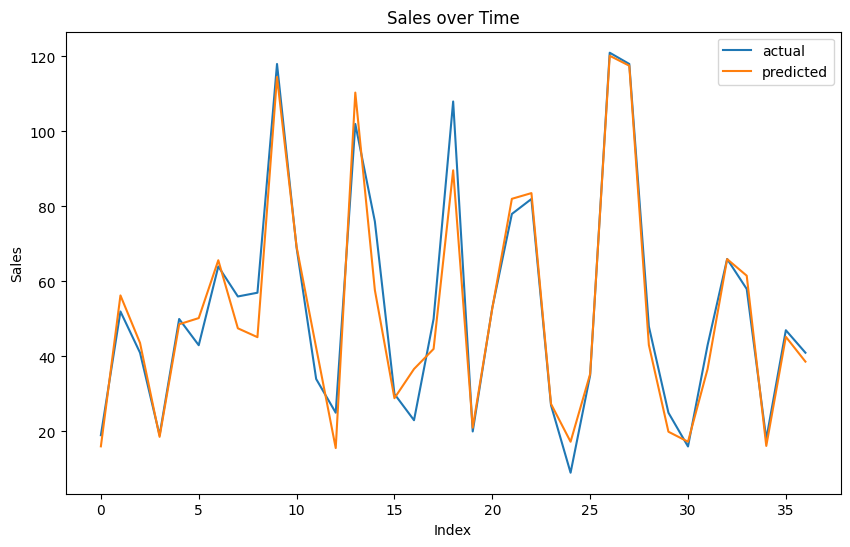

In [ ]:
# prompt: plot a graph of sales

plt.figure(figsize=(10, 6))
plt.plot(arr[0::25000], label = 'actual')
plt.plot(y_pred[0::25000], label = 'predicted')
plt.xlabel('Index     ')
plt.ylabel('Sales')
plt.title('Sales over Time')
plt.legend()
plt.show()